## **Analisis PESOS - TEA Nuevo Horizonte**

In [1]:
import pandas as pd # Dataframes
import numpy as np # Arreglos y matrices
import scipy.stats as stats 
import matplotlib.pyplot as plt # Graficos
import seaborn as sns  # para análisis gráficos
import random # para generar aleatorios

### 0. Funciones

In [2]:
## FUNCION COMPLETITUD
## #######################
## #######################
## #######################

def function_completitud(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Dataframe creados: df_year, df_month')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))



## FUNCION COMPLETITUD PENALIZADA
## #######################
## #######################
## #######################

def function_completitud_pen(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')
    df_merged['FECHA'] = pd.to_datetime(df_merged['FECHA'])
    dim_start = df_merged.shape[0]

    # Filtrar filas donde el día de la semana no sea domingo (domingo es 6)
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 6]
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 5]

    dim_finish = df_merged.shape[0]

    dim_reduccion = dim_finish/dim_start

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    sum_variable_con_datos = df_merged['variable_con_datos'].sum()
    sum_variable_sin_datos = df_merged['variable_sin_datos'].sum()
    pctj_completitud_total = sum_variable_con_datos/(sum_variable_con_datos + sum_variable_sin_datos)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Sin considerar dias sábados/domingos: {dim_reduccion}')
    print(f'Dataframe creados: df_year, df_month')
    print(f'pctj_completitud_total= {pctj_completitud_total}')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))






## FUNCION GRAFICADORA 1
## #######################
## #######################
## #######################

def function_tendencia_unica(df_x, valor,colors='green'):
    df_x = df_x.sort_values(by='FECHA')
    plantacion_name = df_x['PLANTACION'].unique()

    # Si solo te interesa modificar el primer valor (o un único valor) puedes hacer:
    if 'Shanuzi' in plantacion_name:
        plantacion_name = ['Shanuzi']
    else:
        plantacion_name = plantacion_name.tolist()
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_x['FECHA'], df_x[valor], marker='o', markersize=2, linestyle='-', color=colors, label='Pesos')
    # plt.title(f'{plantacion_name[0]}: variable {valor} - a través del Tiempo ')
    plt.title(f'variable {valor} - a través del Tiempo ')
   
    plt.xlabel('Fecha')
    plt.ylabel('Pesos')
    plt.grid(True)
    plt.legend()
    #plt.xticks(rotation=45)

    fecha_min = df_x['FECHA'].min()
    fecha_max = df_x['FECHA'].max()
    print('Analisis de ', fecha_min, ' hasta ', fecha_max)
    
    # Mostrar la gráfica
    # print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
    plt.tight_layout()
    plt.show()




## FUNCION CORRELACION CRUZADA
## #######################
## #######################
## #######################

def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr





## FUNCION SAVE EXCEL
## #######################
## #######################
## #######################

def function_save(df_x):
    # Especifica la ruta donde deseas guardar el CSV
    ruta_save =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx'  # Cambia esta ruta a la que necesites
    df_x.to_excel(ruta_path + ruta_save, index=False)
    print(f'Datos guardados en {ruta_path + ruta_save}')



## FUNCION IMPUTACION OUTLIER
## #######################
## #######################
## #######################

def imputar_valores_extremos(df, variable, metodo='media'):
    """
    Imputa valores extremos en una variable de un DataFrame utilizando la media o la mediana.

    Parámetros:
    df (DataFrame): El DataFrame que contiene la variable a imputar.
    variable (str): El nombre de la variable que deseas imputar.
    metodo (str): La forma de imputación ('media' o 'mediana'). Por defecto es 'media'.

    Retorna:
    DataFrame: El DataFrame con la variable imputada.
    """
    if metodo not in ['media', 'mediana']:
        raise ValueError("El método debe ser 'media' o 'mediana'")

    # Calcular la media o la mediana
    if metodo == 'media':
        valor_imputacion = df[variable].mean()
    else:
        valor_imputacion = df[variable].median()

    # Identificar valores extremos (usando una regla de 3 veces la desviación estándar)
    limite_inferior = df[variable].mean() - 3 * df[variable].std()
    limite_superior = df[variable].mean() + 3 * df[variable].std()

    # Imputar valores extremos
    df[variable] = np.where(
        (df[variable] < limite_inferior) | (df[variable] > limite_superior),
        valor_imputacion,
        df[variable]
    )

    return df



In [ ]:
# pip install scikit-learn

### 1. Carga de datos

In [6]:
# Cargamos el archivo Excel - RFF Procesado
# --------------

ruta_path = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS'               # -> Casa
# ruta_path = 'C:/Users/usuario/Documents/DOCUMENTOS_CONSULTOR_5_BI'      # -> Trabajo


ruta_path_fabrica = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_fabrica_full.csv'
ruta_path_balanza = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_participacion_full.csv'
ruta_path_saldo_campo = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_saldo_campo_full_vf.csv'
ruta_calidad_precipitacion = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_precipitacion_full.csv'
# --
ruta_calidad_racimos_propios = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_racimos_propios_total_full.csv'
ruta_antiguedad_frutos = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_antiguedad_fruta_full.csv'
# --
ruta_calidad_racimos_terceros = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_calidad_terceros_full.csv'
# --
ruta_acidez = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_acidez_full.csv'
# --
ruta_clima = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_clima_full_vf.csv'
# --
ruta__freq_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_freq_cosecha_full.csv'
# --
ruta_participacion_cashcost_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_participacion_cashcost_full.csv'
# --
ruta_perdida_aceite_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_aceite_full.csv'
# --
ruta_perdida_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_otros_full_group.csv'

# --
ruta_polinizadores_pw = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_polinizadores_pw.csv'
ruta_polinizadores_sh = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_polinizadores_sh.csv'


In [5]:
### Cargamos df_sabana_fabrica_full
### --------------------
df_sabana_fabrica_full = pd.read_csv(ruta_path + ruta_path_fabrica)
df_sabana_balanza_full = pd.read_csv(ruta_path + ruta_path_balanza)

df_sabana_saldo_campo_full_vf = pd.read_csv(ruta_path + ruta_path_saldo_campo)
df_sabana_saldo_campo_full_vf['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

df_calidad_precipitacion_full = pd.read_csv(ruta_path + ruta_calidad_precipitacion)
df_calidad_precipitacion_full['FECHA'] = df_calidad_precipitacion_full['FECHA'].str.split(' ').str[0]
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'], format='%Y-%m-%d')

# --
df_calidad_racimos_propios_full = pd.read_csv(ruta_path + ruta_calidad_racimos_propios)
df_calidad_antiguedad_frutos_full = pd.read_csv(ruta_path + ruta_antiguedad_frutos)

# --
df_sabana_calidad_terceros_full = pd.read_csv(ruta_path + ruta_calidad_racimos_terceros)
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'], format='%Y-%m-%d')
df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].replace('-',np.nan)

df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].astype(float)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].astype(float)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].astype(float)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].astype(float)

# --
df_acidez_full = pd.read_csv(ruta_path + ruta_acidez)

# --
df_clima_full_vf = pd.read_csv(ruta_path + ruta_clima)

# --
df_freq_cosecha_full = pd.read_csv(ruta_path + ruta__freq_cosecha)

# --
df_participacion_cashcost_full = pd.read_csv(ruta_path + ruta_participacion_cashcost_full)

# --
df_perdida_aceite_full = pd.read_csv(ruta_path + ruta_perdida_aceite_full,sep = ',')
df_perdida_aceite_full['FECHA'] = pd.to_datetime(df_perdida_aceite_full['FECHA'], format='%Y-%m-%d')

# --
df_perdida_cosecha_full_vf = pd.read_csv(ruta_path + ruta_perdida_cosecha)

# --
# --
df_polinizadores_full_pw = pd.read_csv(ruta_path + ruta_polinizadores_pw, encoding='latin-1',sep = ';')
# --
df_polinizadores_full_sh = pd.read_csv(ruta_path + ruta_polinizadores_sh, encoding='latin-1',sep = ';')
df_polinizadores_full_sh.columns = ['Año', 'Mes', 'Mes_txt', 'PLANTACION', 'NumInsectos','PromInsectosFlor', 'PromInsectosHa']

# Standarizando datos
# ----
df_polinizadores_full_sh['PromInsectosFlor'] = df_polinizadores_full_sh['PromInsectosFlor']/1000
df_polinizadores_full_sh['PromInsectosHa'] = df_polinizadores_full_sh['PromInsectosHa']/1000

# Concatenando datos
# -----
# Concatenar los DataFrames
df_polinizadores_full = pd.concat([df_polinizadores_full_pw, df_polinizadores_full_sh], ignore_index=True)
# Crear la columna 'FECHA' combinando 'año','mes','dia'
df_polinizadores_full['Dia'] = 1 # Agregar una columna de 'día' con un valor predeterminado (por ejemplo, 1)
df_polinizadores_full.rename(columns={'Año': 'year', 'Mes': 'month', 'Dia': 'day'}, inplace=True) # Renombrar las columnas para que pandas las reconozca correctamente
df_polinizadores_full['FECHA'] = pd.to_datetime(df_polinizadores_full[['year', 'month', 'day']]) # Crear la columna 'FECHA' combinando 'year', 'month' y 'day'


### 2. Construyendo DataFrame consolidado

In [7]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
# sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'
sede_analisis = 'Nuevo Horizonte'
# sede_analisis = 'Tulumayo'


# -------
# ---


#### TEA propios vs terceros

In [9]:
df_participacion_cashcost_full['FECHA'] = pd.to_datetime(df_participacion_cashcost_full['FECHA'])
df_analisis_tendencia =  df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == sede_analisis]
df_analisis_tendencia.head()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION
2,20190102,3006,NH,121.80,0.00,121.80,31.09,4.53060,26.55940,2019-01-02,Nuevo Horizonte
5,20190103,3006,NH,114.80,0.00,114.80,26.94,3.92584,23.01416,2019-01-03,Nuevo Horizonte
8,20190104,3006,NH,143.00,56.58,86.42,33.05,4.81623,28.23377,2019-01-04,Nuevo Horizonte
11,20190105,3006,NH,238.08,34.73,203.35,57.51,8.38067,49.12933,2019-01-05,Nuevo Horizonte
14,20190106,3006,NH,134.40,0.00,134.40,31.56,4.59910,26.96090,2019-01-06,Nuevo Horizonte


In [10]:
## REDUCIENDO LA BASE A SEMANA
## --------
## --------

# Crear columna 'SEMANA'
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                           'RFFProcesadoPropios':'sum',
                                                                                           'RFFProcesadoTerceros':'sum',
                                                                                           'CPOObtenidoPropios':'sum',
                                                                                           'CPOObtenidoTerceros':'sum',
                                                                                           'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenidoPropios', 'CPOObtenidoTerceros','CPOObtenido']
df_analisis_tendencia_semana['TEA_total'] = df_analisis_tendencia_semana['CPOObtenido']/df_analisis_tendencia_semana['RFFProcesado']
df_analisis_tendencia_semana['TEA_propios'] = df_analisis_tendencia_semana['CPOObtenidoPropios']/df_analisis_tendencia_semana['RFFProcesadoPropios']
df_analisis_tendencia_semana['TEA_terceros'] = df_analisis_tendencia_semana['CPOObtenidoTerceros']/df_analisis_tendencia_semana['RFFProcesadoTerceros']
df_analisis_tendencia_semana.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\224845057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenidoPropios,CPOObtenidoTerceros,CPOObtenido,TEA_total,TEA_propios,TEA_terceros
0,2018-12-31,Nuevo Horizonte,752.08,91.31,660.77,26.25244,153.89756,180.15,0.239536,0.287509,0.232906
1,2019-01-07,Nuevo Horizonte,1083.54,234.92,848.62,38.08244,223.24756,261.33,0.241182,0.162108,0.263071
2,2019-01-14,Nuevo Horizonte,1305.18,210.46,1094.72,45.27836,265.43164,310.71,0.238059,0.215140,0.242465
3,2019-01-21,Nuevo Horizonte,971.46,115.46,856.00,32.87713,192.73287,225.61,0.232238,0.284749,0.225155
4,2019-01-28,Nuevo Horizonte,894.02,101.39,792.63,29.03297,178.21703,207.25,0.231818,0.286349,0.224843


In [ ]:
df_analisis_tendencia_semana.columns

In [11]:
columns_tea = ['FECHA','PLANTACION','TEA_total','RFFProcesado','RFFProcesadoPropios','RFFProcesadoTerceros','CPOObtenido']
df_tea_propios_terceros = df_analisis_tendencia_semana[columns_tea]
df_tea_propios_terceros.head()


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido
0,2018-12-31,Nuevo Horizonte,0.239536,752.08,91.31,660.77,180.15
1,2019-01-07,Nuevo Horizonte,0.241182,1083.54,234.92,848.62,261.33
2,2019-01-14,Nuevo Horizonte,0.238059,1305.18,210.46,1094.72,310.71
3,2019-01-21,Nuevo Horizonte,0.232238,971.46,115.46,856.00,225.61
4,2019-01-28,Nuevo Horizonte,0.231818,894.02,101.39,792.63,207.25


In [13]:
function_save(df_tea_propios_terceros)

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


#### Calidad de Racimos Propios

In [12]:
# Completando datos con Peso balanza de Propios y terceros
# ----
df_sabana_balanza_full['FECHA'] = pd.to_datetime(df_sabana_balanza_full['FECHA'])
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])
df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN


In [13]:
print(f'dimension inicial: {df_calidad_racimos_propios_full.shape}')

df_calidad_racimos_propios_full_v2 = pd.merge(df_calidad_racimos_propios_full,
                                              df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS']],
                                              on = ['FECHA','PLANTACION'],
                                              how = 'outer')

df_calidad_racimos_propios_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full_v2['FECHA'])
df_calidad_racimos_propios_full_v2['Peso_propios'] = df_calidad_racimos_propios_full_v2['PROPIOS']*1000
df_calidad_racimos_propios_full_v2['PCTJ'] = df_calidad_racimos_propios_full_v2['Peso']/df_calidad_racimos_propios_full_v2['Peso_propios']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)

print(f'dimension final: {df_calidad_racimos_propios_full_v2.shape}')
df_calidad_racimos_propios_full_v2.head()

dimension inicial: (2538, 11)
dimension final: (5480, 14)


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\381160290.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN
1,2020-01-02,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.66,625660.0,NaN
2,2020-01-02,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
3,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN
4,2020-01-03,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.49,777490.0,NaN


In [14]:
# --------
# ---

min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_propios_filter = df_calidad_racimos_propios_full_v2[df_calidad_racimos_propios_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])

print(df_calidad_racimos_propios_filter.PLANTACION.unique())
df_calidad_racimos_propios_filter.head()

df_sabana_balanza_full: 2020-01-02 00:00:00
df_calidad_racimos_propios_full 2022-01-03 00:00:00
['Nuevo Horizonte']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\175372827.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN
3,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN
6,2020-01-04,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.62,33620.0,NaN
10,2020-01-06,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.01,35010.0,NaN
17,2020-01-09,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.46,26460.0,NaN


In [15]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede Palmawasi
# fecha_limite = pd.Timestamp('2022-01-03') ## --> Para sede Shanuzi
# fecha_limite = pd.Timestamp('2020-01-03') ## --> Para sede Tulumayo
# fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede Nuevo Horizonte

df_filtrado =  df_calidad_racimos_propios_filter[df_calidad_racimos_propios_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN
3,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN
6,2020-01-04,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.62,33620.0,NaN
10,2020-01-06,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.01,35010.0,NaN
17,2020-01-09,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.46,26460.0,NaN


In [16]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'Peso':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
# resumen_pctj.iloc[0,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj.iloc[1,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)

    AÑO          Peso
0  2020  0.000000e+00
1  2021  0.000000e+00
2  2022  1.026091e+07
3  2023  9.672632e+06
4  2024  5.665541e+06
---------------------
    AÑO  PCTJ_AÑO
0  2020       NaN
1  2021       NaN
2  2022  0.383409
3  2023  0.703755
4  2024  0.629918


In [17]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN,2020,NaN
1,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN,2020,NaN
2,2020-01-04,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.62,33620.0,NaN,2020,NaN
3,2020-01-06,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.01,35010.0,NaN,2020,NaN
4,2020-01-09,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.46,26460.0,NaN,2020,NaN


In [18]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['Peso'].isna(), df_filtrado['Peso_propios'] * df_filtrado['PCTJ_AÑO'], df_filtrado['Peso'])
df_filtrado.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO,Peso_ajustado
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN,2020,NaN,NaN
1,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN,2020,NaN,NaN
2,2020-01-04,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.62,33620.0,NaN,2020,NaN,NaN
3,2020-01-06,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.01,35010.0,NaN,2020,NaN,NaN
4,2020-01-09,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.46,26460.0,NaN,2020,NaN,NaN


In [19]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_2 = df_filtrado
df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# ----------
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'VERDES':'sum',
                                                                                               'MADUROS':'sum',
                                                                                               'SMADUROS':'sum',
                                                                                               'ESCOBAJO':'sum',
                                                                                               'MALFORMADOA':'sum',
                                                                                               'MALFORMADOB':'sum',
                                                                                               'Peso': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Racimos':'sum',
                                                                                               'Peso_propios':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'VERDES', 'MADUROS', 'SMADUROS', 'ESCOBAJO','MALFORMADOA','MALFORMADOB','Peso','Peso_ajustado','Racimos','Peso_propios']

df_analisis_tendencia_semana_2.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Peso_ajustado,Racimos,Peso_propios
0,2019-12-30,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96610.0
1,2020-01-06,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118700.0
2,2020-01-13,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52610.0
3,2020-01-20,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199350.0
4,2020-01-27,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82530.0


In [21]:
# Creando variables de calidad
# ----

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_semana_2['Peso_CALIDAD'] = df_analisis_tendencia_semana_2[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_analisis_tendencia_semana_2['%_VERDES'] = df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MADUROS'] = df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_SMADUROS'] = df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_ESCOBAJO'] = df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOA'] = df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOB'] = df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']


df_analisis_tendencia_semana_2['Peso_VERDES'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_SMADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_ESCOBAJO'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOA'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOB'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])

df_analisis_tendencia_semana_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_semana_2['FECHA'])


In [ ]:
df_analisis_tendencia_semana_2.head()

In [ ]:
df_analisis_tendencia_semana_2.columns

In [22]:
# Creando df de Calidad Racimos Propios
# -----

columns_rac_propios = ['FECHA', 'PLANTACION','Peso_VERDES','Peso_MADUROS', 'Peso_SMADUROS', 'Peso_ESCOBAJO', 'Peso_MALFORMADOA','Peso_MALFORMADOB']

df_racimos_propios = df_analisis_tendencia_semana_2[columns_rac_propios]
df_racimos_propios.columns = ['FECHA', 'PLANTACION','Peso_VERDES_propios','Peso_MADUROS_propios', 'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios','Peso_MALFORMADOB_propios']

df_racimos_propios.tail()

,FECHA,PLANTACION,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios
239,2024-08-19,Nuevo Horizonte,0.0,281415.416313,2333.783687,0.0,1166.891844,0.000000
240,2024-08-26,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN
241,2024-09-02,Nuevo Horizonte,0.0,348774.360305,3190.757695,0.0,0.000000,1472.657397
242,2024-09-09,Nuevo Horizonte,0.0,297591.789238,586.387762,0.0,0.000000,0.000000
243,2024-09-16,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN


#### Calidad de Racimos Terceros

In [23]:
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'])
df_sabana_calidad_terceros_full.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION
0,2024,Enero,2024-01-02,119.10,0.001538,0.899231,0.099231,0.000000,1,0.0,0.0,0.003846153846153846,0.005384615384615384,Palmawasi
1,2024,Enero,2024-01-03,127.62,0.002914,0.901321,0.093629,0.002137,1,0.0,0.0,0.003496503496503497,0.008352758352758352,Palmawasi
2,2024,Enero,2024-01-04,199.01,0.005461,0.912969,0.080546,0.001024,1,0.0,0.0,0.005460750853242321,0.01023890784982935,Palmawasi
3,2024,Enero,2024-01-05,155.34,0.004018,0.900000,0.094866,0.001116,1,0.0,0.0,0.003348214285714286,0.0078125,Palmawasi
4,2024,Enero,2024-01-06,204.82,0.004518,0.904367,0.089910,0.001205,1,0.0,0.0,0.004518072289156626,0.008433734939759036,Palmawasi


In [24]:
print(f'dimension inicial: {df_sabana_calidad_terceros_full.shape}')

df_calidad_racimos_terceros_full_v2 = pd.merge(df_sabana_calidad_terceros_full,
                                               df_sabana_balanza_full[['FECHA','PLANTACION','TERCEROS']],
                                               on = ['FECHA','PLANTACION'],
                                               how = 'outer')

df_calidad_racimos_terceros_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_full_v2['FECHA'])
df_calidad_racimos_terceros_full_v2['Peso_terceros'] = df_calidad_racimos_terceros_full_v2['TERCEROS']*1000

df_calidad_racimos_terceros_full_v2['PCTJ'] = (df_calidad_racimos_terceros_full_v2['PESO NETO T.M.']*1000)/df_calidad_racimos_terceros_full_v2['Peso_terceros']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_terceros_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_calidad_racimos_terceros_full_v2['% MALFORMADO'].replace('-', np.nan, inplace=True)
df_calidad_racimos_terceros_full_v2['% MALFORMADO'] = df_calidad_racimos_terceros_full_v2['% MALFORMADO'].astype('float')

print(f'dimension final: {df_calidad_racimos_terceros_full_v2.shape}')
df_calidad_racimos_terceros_full_v2.head()

dimension inicial: (3038, 14)
dimension final: (5476, 17)


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\2638733628.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_calidad_racimos_terceros_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\2638733628.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
0,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
1,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palmawasi,0.0,0.0,NaN
2,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
3,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
4,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palmawasi,0.0,0.0,NaN


In [25]:
# Seleccionando la sede para pronosticar
# --------------

min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_sabana_calidad_terceros_full[df_sabana_calidad_terceros_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_terceros_filter = df_calidad_racimos_terceros_full_v2[df_calidad_racimos_terceros_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_terceros_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_filter['FECHA'])

print(df_calidad_racimos_terceros_filter.PLANTACION.unique())
df_calidad_racimos_terceros_filter.head()


df_sabana_balanza_full: 2020-01-02 00:00:00
df_calidad_racimos_propios_full 2022-08-19 00:00:00
['Nuevo Horizonte']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\3025376969.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calidad_racimos_terceros_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_filter['FECHA'])


,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
0,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
3,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
6,NaN,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
10,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
17,NaN,NaN,2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN


In [26]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16

# echa_limite = pd.Timestamp('2020-01-02') ## --> Para sede Pamawasi
# fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede shanusi
# fecha_limite = pd.Timestamp('2020-01-03') ## --> Para sede Tulumayo
fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede Nuevo Horizonte

df_filtrado =  df_calidad_racimos_terceros_filter[df_calidad_racimos_terceros_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
0,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
3,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
6,NaN,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
10,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
17,NaN,NaN,2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN


In [27]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'PESO NETO T.M.':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
# resumen_pctj.iloc[0,1] = 0.998181 ## --> Para Palmawasi
# resumen_pctj.iloc[1,1] = 0.998181 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)


    AÑO  PESO NETO T.M.
0  2020            0.00
1  2021            0.00
2  2022        28723.14
3  2023        73441.72
4  2024        45032.14
---------------------
    AÑO  PCTJ_AÑO
0  2020       NaN
1  2021       NaN
2  2022  0.999038
3  2023  0.999904
4  2024  1.000182


In [28]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ,PCTJ_AÑO
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN
4,2020,NaN,2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN


In [29]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['PESO NETO T.M.'].isna(), df_filtrado['Peso_terceros'] * df_filtrado['PCTJ_AÑO'], df_filtrado['PESO NETO T.M.']*1000)
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ,PCTJ_AÑO,Peso_ajustado
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN,NaN
4,2020,NaN,2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN,NaN,NaN


In [30]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############

df_analisis_tendencia_3 = df_filtrado
df_analisis_tendencia_3['FECHA'] = pd.to_datetime(df_analisis_tendencia_3['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_3['SEMANA'] = df_analisis_tendencia_3['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

In [31]:
# VARIABLES CALIDAD MES
# -------
# ---

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_3['Peso_VERDES'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% VERDES'])
df_analisis_tendencia_3['Peso_MADUROS'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% MADUROS'])
df_analisis_tendencia_3['Peso_SMADUROS'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% SMADUROS'])
df_analisis_tendencia_3['Peso_ESCOBAJO'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% ESCOBAJO'])
df_analisis_tendencia_3['Peso_MALFORMADO'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% MALFORMADO'])

df_analisis_tendencia_3['FECHA'] = pd.to_datetime(df_analisis_tendencia_3['FECHA'])
df_analisis_tendencia_3.head()


,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,...,Peso_terceros,PCTJ,PCTJ_AÑO,Peso_ajustado,SEMANA,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADO
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN
4,2020,NaN,2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN


In [32]:
# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_3 = df_analisis_tendencia_3.groupby(['SEMANA','PLANTACION']).agg({'Peso_VERDES':'sum',
                                                                                               'Peso_MADUROS':'sum',
                                                                                               'Peso_SMADUROS':'sum',
                                                                                               'Peso_ESCOBAJO':'sum',
                                                                                               'Peso_MALFORMADO':'sum',
                                                                                               'PESO NETO T.M.': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Peso_terceros':'sum'}).reset_index()

df_analisis_tendencia_semana_3.columns = ['FECHA', 'PLANTACION', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS','Peso_ESCOBAJO', 'Peso_MALFORMADO', 'PESO NETO T.M.', 'Peso_ajustado','Peso_terceros']


In [ ]:
df_analisis_tendencia_semana_3.head()

In [33]:
# Creando df de Calidad Racimos Terceros
# -----

columns_rac_terceros = ['FECHA', 'PLANTACION', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS','Peso_ESCOBAJO','Peso_MALFORMADO']

df_racimos_terceros = df_analisis_tendencia_semana_3[columns_rac_terceros]
df_racimos_terceros.columns = ['FECHA', 'PLANTACION', 'Peso_VERDES_terceros', 'Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros']

df_racimos_terceros.tail()

,FECHA,PLANTACION,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,Peso_MALFORMADO_terceros
239,2024-08-19,Nuevo Horizonte,5678.489111,1.581146e+06,31727.506431,1958.345296,20830.166277
240,2024-08-26,Nuevo Horizonte,5721.904152,1.548263e+06,30419.431855,1415.757561,21120.605430
241,2024-09-02,Nuevo Horizonte,5792.055637,1.645423e+06,33788.601430,1996.082883,22517.746682
242,2024-09-09,Nuevo Horizonte,7635.091354,1.725731e+06,46012.491941,2001.063912,23888.669677
243,2024-09-16,Nuevo Horizonte,2776.407446,6.000081e+05,9719.437731,536.044239,6832.804308


#### Precipitación

In [34]:
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'])
df_analisis_tendencia_precip =  df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == sede_analisis]
df_analisis_tendencia_precip.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2019-01-01,Nuevo Horizonte,0.0
2,2019-01-02,Nuevo Horizonte,0.0
4,2019-01-03,Nuevo Horizonte,0.0
6,2019-01-04,Nuevo Horizonte,0.0
8,2019-01-05,Nuevo Horizonte,0.0


In [35]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA'
df_analisis_tendencia_semana_precip = df_analisis_tendencia_precip.groupby(['SEMANA','PLANTACION']).agg({'PRECIPITACION_TOTAL': 'sum'}).reset_index()
df_analisis_tendencia_semana_precip.columns = ['FECHA','PLANTACION','PRECIPITACION_TOTAL']
df_analisis_tendencia_semana_precip.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\2783261855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2018-12-31,Nuevo Horizonte,0.0
1,2019-01-07,Nuevo Horizonte,185.9
2,2019-01-14,Nuevo Horizonte,29.2
3,2019-01-21,Nuevo Horizonte,110.7
4,2019-01-28,Nuevo Horizonte,94.5


In [36]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH'] = df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2'].shift(32)

df_analisis_tendencia_semana_precip.tail()

,FECHA,PLANTACION,PRECIPITACION_TOTAL,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH
264,2024-02-12,Nuevo Horizonte,52.5,55.25,16.5
265,2024-02-19,Nuevo Horizonte,67.5,60.00,3.5
266,2024-02-26,Nuevo Horizonte,135.5,101.50,3.0
267,2024-03-04,Nuevo Horizonte,46.0,90.75,5.7
268,2024-03-11,Nuevo Horizonte,8.0,27.00,2.7


In [37]:
# Creando df de Calidad Racimos Terceros
# -----

columns_precipitacion = ['FECHA', 'PLANTACION', 'PRECIPITACION_TOTAL_rolling_2','PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH']

df_precipitacion = df_analisis_tendencia_semana_precip[columns_precipitacion]
df_precipitacion.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH
0,2018-12-31,Nuevo Horizonte,NaN,NaN
1,2019-01-07,Nuevo Horizonte,92.95,NaN
2,2019-01-14,Nuevo Horizonte,107.55,NaN
3,2019-01-21,Nuevo Horizonte,69.95,NaN
4,2019-01-28,Nuevo Horizonte,102.60,NaN


In [ ]:
df_precipitacion.groupby('PLANTACION').agg({'FECHA':['min','max']})

In [ ]:
df_calidad_precipitacion_full.groupby('PLANTACION').agg({'FECHA':['min','max']})

#### Saldos en Campo

In [38]:
df_sabana_saldo_campo_full_vf_filter = df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == sede_analisis]
df_sabana_saldo_campo_full_vf_filter['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

# Recode
# ---
df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 2'] = df_sabana_saldo_campo_full_vf_filter['DIA 2'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 3'] = df_sabana_saldo_campo_full_vf_filter['DIA 3'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 4'] = df_sabana_saldo_campo_full_vf_filter['DIA 4'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 5'] = df_sabana_saldo_campo_full_vf_filter['DIA 5'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 6'] = df_sabana_saldo_campo_full_vf_filter['DIA 6'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 7'] = df_sabana_saldo_campo_full_vf_filter['DIA 7'].replace('-',np.nan).astype(float)

df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 2'] = df_sabana_saldo_campo_full_vf_filter['DIA 2'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 3'] = df_sabana_saldo_campo_full_vf_filter['DIA 3'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 4'] = df_sabana_saldo_campo_full_vf_filter['DIA 4'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 5'] = df_sabana_saldo_campo_full_vf_filter['DIA 5'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 6'] = df_sabana_saldo_campo_full_vf_filter['DIA 6'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 7'] = df_sabana_saldo_campo_full_vf_filter['DIA 7'].replace(np.nan,0)


print(df_sabana_saldo_campo_full_vf_filter.PLANTACION.unique())
df_sabana_saldo_campo_full_vf_filter.head()

[nan]


,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7
0,2023-05-01,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-05-02,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-05-03,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-05-04,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-05-05,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Añadiendo columnas de saldos
# -----
df_sabana_saldo_campo_full_vf_filter['SALDO > 2'] = df_sabana_saldo_campo_full_vf_filter[['DIA 2','DIA 3','DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
df_sabana_saldo_campo_full_vf_filter['SALDO > 4'] = df_sabana_saldo_campo_full_vf_filter[['DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
df_sabana_saldo_campo_full_vf_filter['SALDO > 5'] = df_sabana_saldo_campo_full_vf_filter[['DIA 5','DIA 6','DIA 7']].sum(axis=1)

df_sabana_saldo_campo_full_vf_filter.head()

,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7,SALDO > 2,SALDO > 4,SALDO > 5
0,2023-05-01,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-05-02,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-05-03,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-05-04,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-05-05,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_saldo_campo = df_sabana_saldo_campo_full_vf_filter
df_analisis_tendencia_2_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_saldo_campo['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo['SEMANA'] = df_analisis_tendencia_2_saldo_campo['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo.head()

,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7,SALDO > 2,SALDO > 4,SALDO > 5,SEMANA
0,2023-05-01,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-05-01
1,2023-05-02,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-05-01
2,2023-05-03,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-05-01
3,2023-05-04,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-05-01
4,2023-05-05,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-05-01


In [41]:
# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_saldo_campo = df_analisis_tendencia_2_saldo_campo.groupby(['SEMANA','PLANTACION']).agg({'SALDO':'sum',
                                                                                           'SALDO > 2':'sum',
                                                                                           'SALDO > 3':'sum',
                                                                                           'SALDO > 4':'sum',
                                                                                           'SALDO > 5':'sum'}).reset_index()

df_saldo_campo.columns = ['FECHA','PLANTACION', 'SALDO','SALDO > 2','SALDO > 3','SALDO > 4','SALDO > 5']
df_saldo_campo.head()

,FECHA,PLANTACION,SALDO,SALDO > 2,SALDO > 3,SALDO > 4,SALDO > 5


#### Perdidas en Fabrica

In [42]:
print(df_perdida_aceite_full.PLANTACION.unique())
df_perdida_aceite_full.head()

['Nuevo Horizonte' 'Palmawasi' 'Shanuzi' 'Tulumayo']


,AÑO,MES,DIA,RFF PROCESADO,TM CONDENSADO,TM ACEITE CONDENSADO,% PERDIDA ACEITE CONDENSADO,TM ESCOBAJO SIN PICAR,TM ACEITE ESCOBAJO SIN PICAR,% PERDIDA ACEITE ESCOBAJO SIN PICAR,...,LODO,FRUTO ADHERIDO,ARENA,TM ACEITE ESCOBAJO,TM ACEITE ESCOBAJO_CMPTO,TM ACEITE CONDENSADO_CMPTO,TM ACEITE FIBRA_CMPTO,TM ACEITE AGUA TD_CMPTO,TM ACEITE EN ARENA_CMPTO,TM ACEITE CASCARA_CMPTO
0,2020.0,Enero,2020-01-01 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020.0,Enero,2020-01-01 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020.0,Enero,2020-01-01 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020.0,Enero,2020-01-02 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020.0,Enero,2020-01-02 00:00:00,914.62,192.0702,0.0,0,0.0,0.0,0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Variable pérdidas
# ---------

df_perdida_aceite_full.columns

# TM ACEITE CONDENSADO

# TM ACEITE ESCOBAJO SIN PICAR
# TM ACEITE ESCOBAJO PICADO

# TM ACEITE RACIMO MAL DESFRUTADO

# TM ACEITE FIBRA

# TM ACEITE AGUA TD

# TM ACEITE SOLIDO TD

# TM ACEITE EN ARENA

# TM ACEITE CASCARA

# Hay nuevas perdidas que no los quieren conciderar
# ----------
# TM RACIMOS DUROS
# TM RACIMOS MAL DESFRUTADOS

In [43]:
# Filtrando la base total por sedes
# --------

# Creamos PERDIDA EN ACEITE ESCOBAJO
# ----
# df_perdida_aceite_full['TM ACEITE ESCOBAJO'] = df_perdida_aceite_full['TM ACEITE ESCOBAJO SIN PICAR'] + df_perdida_aceite_full['TM ACEITE ESCOBAJO PICADO']

df_perdida_aceite_full['TM PERDIDA TOTAL'] = (
    df_perdida_aceite_full['TM ACEITE CONDENSADO_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE ESCOBAJO_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE RACIMO MAL DESFRUTADO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE FIBRA_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE AGUA TD_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE SOLIDO TD'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE EN ARENA_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE CASCARA_CMPTO'].fillna(0)
)# ----

df_perdida_aceite_full_filter = df_perdida_aceite_full[df_perdida_aceite_full['PLANTACION'] == sede_analisis]
df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])

print(df_perdida_aceite_full_filter.PLANTACION.unique())
df_perdida_aceite_full_filter.tail()


['Nuevo Horizonte']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\3194910366.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])


,AÑO,MES,DIA,RFF PROCESADO,TM CONDENSADO,TM ACEITE CONDENSADO,% PERDIDA ACEITE CONDENSADO,TM ESCOBAJO SIN PICAR,TM ACEITE ESCOBAJO SIN PICAR,% PERDIDA ACEITE ESCOBAJO SIN PICAR,...,FRUTO ADHERIDO,ARENA,TM ACEITE ESCOBAJO,TM ACEITE ESCOBAJO_CMPTO,TM ACEITE CONDENSADO_CMPTO,TM ACEITE FIBRA_CMPTO,TM ACEITE AGUA TD_CMPTO,TM ACEITE EN ARENA_CMPTO,TM ACEITE CASCARA_CMPTO,TM PERDIDA TOTAL
6470,2024.0,Diciembre,2024-12-27 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6473,2024.0,Diciembre,2024-12-28 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6476,2024.0,Diciembre,2024-12-29 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6479,2024.0,Diciembre,2024-12-30 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6482,2024.0,Diciembre,2024-12-31 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [44]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_perdida_aceite = df_perdida_aceite_full_filter
df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2_perdida_aceite = df_analisis_tendencia_2_perdida_aceite.groupby(['SEMANA','PLANTACION']).agg({'TM PERDIDA TOTAL':'sum',
                                                                                                                             'TM ACEITE CONDENSADO_CMPTO':'sum',
                                                                                                                             'TM ACEITE ESCOBAJO_CMPTO':'sum',
                                                                                                                             'TM ACEITE RACIMO MAL DESFRUTADO':'sum',
                                                                                                                             'TM ACEITE FIBRA_CMPTO':'sum',
                                                                                                                             'TM ACEITE AGUA TD_CMPTO':'sum',
                                                                                                                             'TM ACEITE SOLIDO TD':'sum',
                                                                                                                             'TM ACEITE EN ARENA_CMPTO':'sum',
                                                                                                                             'TM ACEITE CASCARA_CMPTO':'sum'}).reset_index()

df_analisis_tendencia_semana_2_perdida_aceite.columns = ['FECHA','PLANTACION','TM PERDIDA TOTAL' ,'TM ACEITE CONDENSADO', 'TM ACEITE ESCOBAJO','TM ACEITE RACIMO MAL DESFRUTADO', 'TM ACEITE FIBRA','TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD', 'TM ACEITE EN ARENA','TM ACEITE CASCARA']
df_analisis_tendencia_semana_2_perdida_aceite.head()


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\2245403583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\2245403583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2019-12-30,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-06,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-13,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-20,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-27,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df_perdidas_aceite = df_analisis_tendencia_semana_2_perdida_aceite
df_perdidas_aceite.head()

,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2019-12-30,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-06,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-13,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-20,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-27,Nuevo Horizonte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Polinizadores

In [46]:
print(df_polinizadores_full.PLANTACION.unique())
df_polinizadores_full.head()

['Palmawasi' 'Shanuzi']


,year,month,Mes_txt,PLANTACION,NumInsectos,PromInsectosFlor,PromInsectosHa,day,FECHA
0,2018,1,Ene,Palmawasi,512099,11.40,55.91,1,2018-01-01
1,2018,2,Feb,Palmawasi,550568,10.10,52.41,1,2018-02-01
2,2018,3,Mar,Palmawasi,492468,10.29,51.22,1,2018-03-01
3,2018,4,Abr,Palmawasi,487876,10.05,56.25,1,2018-04-01
4,2018,5,May,Palmawasi,579719,10.35,69.26,1,2018-05-01


In [47]:
df_polinizadores_full['FECHA'] = pd.to_datetime(df_polinizadores_full['FECHA'])
df_polinizadores_full_filter =  df_polinizadores_full[df_polinizadores_full['PLANTACION'] == sede_analisis]

print(df_polinizadores_full_filter.PLANTACION.unique())
df_polinizadores_full_filter.head()

[]


,year,month,Mes_txt,PLANTACION,NumInsectos,PromInsectosFlor,PromInsectosHa,day,FECHA


In [48]:
# Crear una lista para almacenar los nuevos registros semanales
data_semanal = []

# Iterar sobre cada registro mensual
for index, row in df_polinizadores_full_filter.iterrows():
    fecha = row['FECHA']
    prom_insectos_flor = row['PromInsectosFlor']
    prom_insectos_ha = row['PromInsectosHa']
    num_insectos = row['NumInsectos']
    
    # Calcular la cantidad de semanas en el mes
    # Se considera que cada semana empieza el lunes
    inicio_mes = fecha
    fin_mes = inicio_mes + pd.offsets.MonthEnd(0)
    semanas_en_mes = pd.date_range(start=inicio_mes, end=fin_mes, freq='W-MON')
    
    # Número de semanas en el mes
    num_semanas = len(semanas_en_mes)
    
    # Calcular el número de insectos por semana
    num_insectos_por_semana = num_insectos / num_semanas
    
    # Crear un nuevo registro para cada semana
    for semana in semanas_en_mes:
        data_semanal.append({
            'FECHA': semana,
            'PromInsectosFlor': prom_insectos_flor,
            'PromInsectosHa': prom_insectos_ha,
            'NumInsectos': num_insectos_por_semana
        })

In [49]:
# Crear un nuevo DataFrame con los datos semanales
df_polinizadores_semanal = pd.DataFrame(data_semanal)
df_polinizadores_semanal['PLANTACION'] = sede_analisis
df_polinizadores_semanal.head(10)

,PLANTACION


In [ ]:
function_tendencia_unica(df_polinizadores_semanal, 'NumInsectos')

In [ ]:
df_polinizadores_semanal['NumInsectos_SHIFTED_4_MONTH'] = df_polinizadores_semanal['NumInsectos'].shift(16)
df_polinizadores_semanal.head()

In [ ]:
df_polinizadores_sem = df_polinizadores_semanal[['FECHA','PLANTACION','NumInsectos','NumInsectos_SHIFTED_4_MONTH']]
df_polinizadores_sem

#### Consolidando df para modelo

In [ ]:
df_tea_propios_terceros
df_racimos_propios
df_racimos_terceros
df_precipitacion
# df_saldo_campo
df_perdidas_aceite
# df_polinizadores_sem

In [ ]:
# df_tea_propios_terceros[df_tea_propios_terceros['FECHA'] > '2022-01-01'].head() ## shanusi
df_tea_propios_terceros[df_tea_propios_terceros['FECHA'] > '2019-12-20'].head() ## shanusi

In [ ]:
df_racimos_terceros.head()

In [51]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
# ---------------
# -----------
df_model_match = pd.merge(df_tea_propios_terceros,df_racimos_propios,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_racimos_terceros,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_precipitacion,on=['FECHA', 'PLANTACION'], how='outer')
# df_model_match = pd.merge(df_model_match,df_saldo_campo,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_perdidas_aceite,on=['FECHA', 'PLANTACION'], how='outer')
# df_model_match = pd.merge(df_model_match,df_polinizadores_sem,on=['FECHA', 'PLANTACION'], how='outer')


# Convertir 'FECHA' a formato datetime
df_model_match['FECHA'] = pd.to_datetime(df_model_match['FECHA'])

print(df_model_match.PLANTACION.unique())
print('df_model_match:',df_model_match.shape)
print('-------------')
print('df_tea_propios_terceros:',df_tea_propios_terceros.shape)
print('df_racimos_propios:',df_racimos_propios.shape)
print('df_racimos_terceros:',df_racimos_terceros.shape)
print('df_precipitacion:',df_precipitacion.shape)
# print('df_saldo_campo:',df_saldo_campo.shape)
print('df_perdidas_aceite:',df_perdidas_aceite.shape)
# print('df_polinizadores_sem:',df_polinizadores_sem.shape)

df_model_match.head()


['Nuevo Horizonte']
df_model_match: (314, 29)
-------------
df_tea_propios_terceros: (292, 7)
df_racimos_propios: (244, 8)
df_racimos_terceros: (244, 7)
df_precipitacion: (269, 4)
df_perdidas_aceite: (262, 11)


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2018-12-31,Nuevo Horizonte,0.239536,752.08,91.31,660.77,180.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-07,Nuevo Horizonte,0.241182,1083.54,234.92,848.62,261.33,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-14,Nuevo Horizonte,0.238059,1305.18,210.46,1094.72,310.71,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-21,Nuevo Horizonte,0.232238,971.46,115.46,856.00,225.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-28,Nuevo Horizonte,0.231818,894.02,101.39,792.63,207.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
function_save(df_model_match)

In [53]:
# Extraer el año de la columna FECHA
df_model_match['anio'] = df_model_match['FECHA'].dt.year
df_model_match.head()

,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,anio
0,2018-12-31,Nuevo Horizonte,0.239536,752.08,91.31,660.77,180.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
1,2019-01-07,Nuevo Horizonte,0.241182,1083.54,234.92,848.62,261.33,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
2,2019-01-14,Nuevo Horizonte,0.238059,1305.18,210.46,1094.72,310.71,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
3,2019-01-21,Nuevo Horizonte,0.232238,971.46,115.46,856.00,225.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
4,2019-01-28,Nuevo Horizonte,0.231818,894.02,101.39,792.63,207.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019


In [54]:
# Reemplazar valores de 0 por np.nan en todo el DataFrame
df_model_match.replace(0, np.nan, inplace=True)

# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_model_match.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_model_match.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1522600855.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_model_match.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1522600855.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentaj

Valores Perdidos Absolutos       \
anio                                                                2018 2019   
RFFProcesadoTerceros                                                   0    0   
CPOObtenido                                                            0    0   
Peso_VERDES_propios                                                    1   52   
Peso_MADUROS_propios                                                   1   52   
Peso_SMADUROS_propios                                                  1   52   
Peso_ESCOBAJO_propios                                                  1   52   
Peso_MALFORMADOA_propios                                               1   52   
Peso_MALFORMADOB_propios                                               1   52   
Peso_VERDES_terceros                                                   1   52   
Peso_MADUROS_terceros                                                  1   52   
Peso_SMADUROS_terceros                                                 1   52   
Peso_ESCOBAJO_terceros                                                 1   52   
Peso_MALFORMADO_terceros                                               1   52   
PRECIPITACION_TOTAL_rolling_2                                          1    2   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH                          1   32   
TM PERDIDA TOTAL                                                       1   52   
TM ACEITE CONDENSADO                                                   1   52   
TM ACEITE ESCOBAJO                                                     1   52   
TM ACEITE RACIMO MAL DESFRUTADO                                        1   52   
TM ACEITE FIBRA                                                        1   52   
TM ACEITE AGUA TD                                                      1   52   
TM ACEITE SOLIDO TD                                                    1   52   
TM ACEITE EN ARENA                                                     1   52   
TM ACEITE CASCARA                                                      1   52   
anio                                                                   0    0   

                                                                        \
anio                                          2020 2021 2022 2023 2024   
RFFProcesadoTerceros                             0    0    0    0   22   
CPOObtenido                                      2    0    1    0   22   
Peso_VERDES_propios                             52   52   52   50   51   
Peso_MADUROS_propios                            52   52   52   48   24   
Peso_SMADUROS_propios                           52   52   52   49   25   
Peso_ESCOBAJO_propios                           52   52   52   52   53   
Peso_MALFORMADOA_propios                        52   52   52   48   37   
Peso_MALFORMADOB_propios                        52   52   52   52   52   
Peso_VERDES_terceros                            52   52   33    0   15   
Peso_MADUROS_terceros                           52   52   33    0   15   
Peso_SMADUROS_terceros                          52   52   33    0   15   
Peso_ESCOBAJO_terceros                          52   52   34    0   15   
Peso_MALFORMADO_terceros                        52   52   33    0   15   
PRECIPITACION_TOTAL_rolling_2                    4    0    2    1   42   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH    5    1    0    2   42   
TM PERDIDA TOTAL                                52   38    1    0   16   
TM ACEITE CONDENSADO                            52   52   52    0   16   
TM ACEITE ESCOBAJO                              52   38    1    0   16   
TM ACEITE RACIMO MAL DESFRUTADO                 52   51    2   52   22   
TM ACEITE FIBRA                                 52   38    1    0   16   
TM ACEITE AGUA TD                               52   38    1    0   16   
TM ACEITE SOLIDO TD                             52   52   52   52   16   
TM ACEITE EN ARENA                              52   52   52   38   16   
TM ACEIT

In [55]:
del df_model_match['Peso_ESCOBAJO_propios']
del df_model_match['Peso_MALFORMADOB_propios']
del df_model_match['TM ACEITE RACIMO MAL DESFRUTADO']
del df_model_match['TM ACEITE SOLIDO TD']

Analisis de  2018-12-31 00:00:00  hasta  2024-09-30 00:00:00


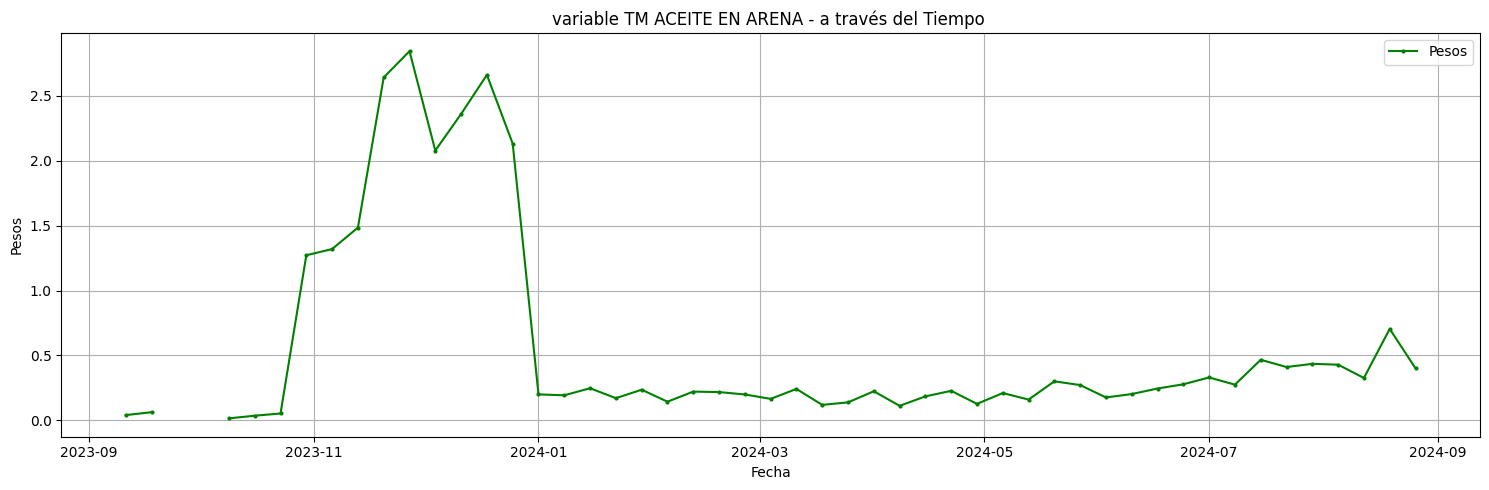

In [64]:
# function_tendencia_unica(df_model_match,'TM ACEITE AGUA TD')
function_tendencia_unica(df_model_match,'TM ACEITE EN ARENA')
# function_tendencia_unica(df_model_match,'PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH')


In [56]:
# Reducimos la base de datos para trabajar con poca presencia de valores perdidos
# -----
fecha_limite_sem_inf = pd.Timestamp('2023-9-01') ## --> Para sede Nuevo Horizonte

fecha_limite_sem_sup = pd.Timestamp('2024-04-01') ## --> Para sede Nuevo Horizonte
# fecha_limite_sem_sup = pd.Timestamp('2024-07-01') ## --> Para sede Nuevo Horizonte

df_regresion =  df_model_match[df_model_match['FECHA'] >= fecha_limite_sem_inf]
df_regresion =  df_regresion[df_regresion['FECHA'] < fecha_limite_sem_sup]
df_regresion.head()


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,anio
244,2023-09-04,Nuevo Horizonte,0.223031,2447.685,435.41,2012.275,545.910,NaN,NaN,NaN,...,12.75,46.50,42.899166,0.714512,22.891857,13.543977,5.082051,NaN,0.666769,2023
245,2023-09-11,Nuevo Horizonte,0.229143,2519.035,543.06,1975.975,577.218,NaN,NaN,NaN,...,17.25,96.70,34.757910,0.495727,14.547189,13.692042,5.410005,0.041662,0.571286,2023
246,2023-09-18,Nuevo Horizonte,0.215559,2504.562,328.46,2176.102,539.880,NaN,NaN,NaN,...,4.50,98.55,47.733108,0.575637,26.547172,14.897563,4.962975,0.063650,0.686111,2023
247,2023-09-25,Nuevo Horizonte,0.233291,2899.214,847.09,2052.124,676.360,NaN,NaN,NaN,...,8.25,45.10,54.066915,1.054792,32.709482,14.690386,4.920676,NaN,0.691579,2023
248,2023-10-02,Nuevo Horizonte,0.241198,2072.785,224.07,1848.715,499.952,NaN,NaN,NaN,...,17.75,70.00,34.941133,0.620793,17.725860,12.643163,3.471024,NaN,0.480293,2023


In [57]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1673673285.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1673673285.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes

Valores Perdidos Absolutos       \
anio                                                                2023 2024   
PLANTACION                                                             0    0   
TEA_total                                                              0    0   
RFFProcesado                                                           0    0   
RFFProcesadoPropios                                                    0    0   
RFFProcesadoTerceros                                                   0    0   
CPOObtenido                                                            0    0   
Peso_VERDES_propios                                                   15   13   
Peso_MADUROS_propios                                                  13    5   
Peso_SMADUROS_propios                                                 14    5   
Peso_MALFORMADOA_propios                                              13    8   
Peso_VERDES_terceros                                                   0    0   
Peso_MADUROS_terceros                                                  0    0   
Peso_SMADUROS_terceros                                                 0    0   
Peso_ESCOBAJO_terceros                                                 0    0   
Peso_MALFORMADO_terceros                                               0    0   
PRECIPITACION_TOTAL_rolling_2                                          0    2   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH                          0    2   
TM PERDIDA TOTAL                                                       0    0   
TM ACEITE CONDENSADO                                                   0    0   
TM ACEITE ESCOBAJO                                                     0    0   
TM ACEITE FIBRA                                                        0    0   
TM ACEITE AGUA TD                                                      0    0   
TM ACEITE EN ARENA                                                     3    0   
TM ACEITE CASCARA                                                      0    0   
anio                                                                   0    0   

                                              Porcentaje          
anio                                                2023    2024  
PLANTACION                                          0.00    0.00  
TEA_total                                           0.00    0.00  
RFFProcesado                                        0.00    0.00  
RFFProcesadoPropios                                 0.00    0.00  
RFFProcesadoTerceros                                0.00    0.00  
CPOObtenido                                         0.00    0.00  
Peso_VERDES_propios                                88.24  100.00  
Peso_MADUROS_propios                               76.47   38.46  
Peso_SMADUROS_propios                              82.35   38.46  
Peso_MALFORMADOA_propios                           76.47   61.54  
Peso_VERDES_terceros                                0.00    0.00  
Peso_MADUROS_terceros                               0.00    0.00  
Peso_SMADUROS_terceros                              0.00    0.00  
Peso_ESCOBAJO_terceros                              0.00    0.00  
Peso_MALFORMADO_terceros                            0.00    0.00  
PRECIPITACION_TOTAL_rolling_2                       0.00   15.38  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH       0.00   15.38  
TM PERDIDA TOTAL                                    0.00    0.00  
TM ACEITE CONDENSADO                                0.00    0.00  
TM ACEITE ESCOBAJO                                  0.00    0.00  
TM ACEITE FIBRA                                     0.00    0.00  
TM ACEITE AGUA TD                                   0.00    0.00  
TM ACEITE EN ARENA                                 17.65    0.00  
TM ACEITE CASCARA                                   0.00    0.00  
anio                                                0.00    0.00

Analisis de  2023-09-04 00:00:00  hasta  2024-03-25 00:00:00


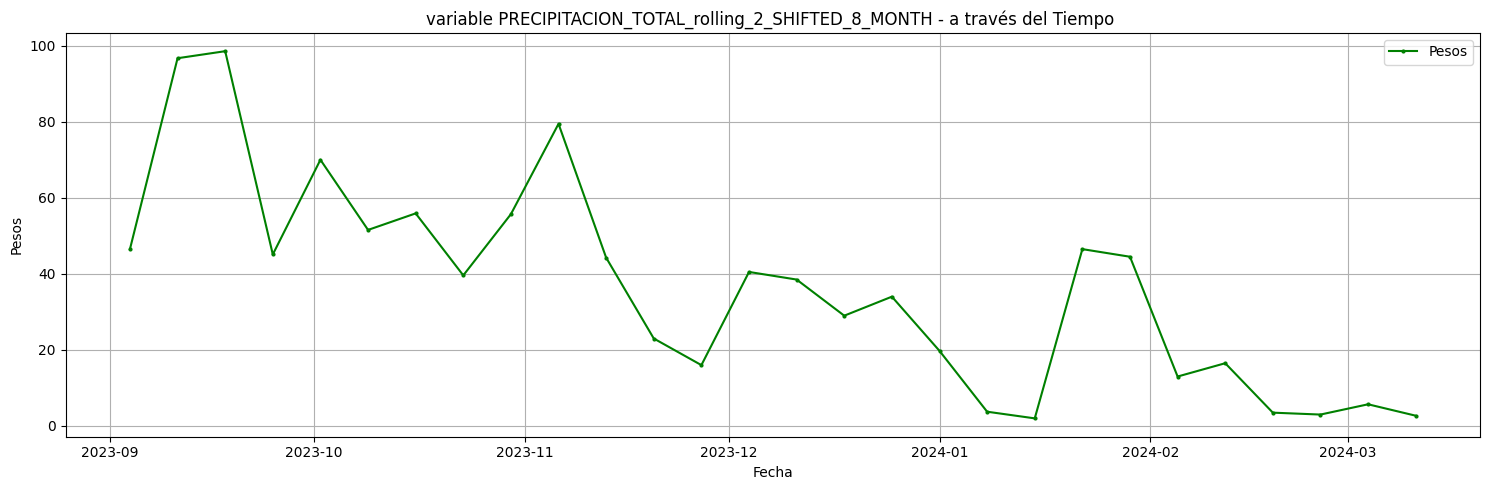

In [67]:
function_tendencia_unica(df_regresion, 'PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH')
# function_tendencia_unica(df_regresion, 'SALDO > 5')
# function_tendencia_unica(df_regresion, 'Peso_VERDES_propios')

In [58]:
# Eliminamos variables con mucha presencia de missing
# -----
del df_regresion['Peso_VERDES_propios'] # Muchos valores vacios
del df_regresion['Peso_MADUROS_propios'] # Muchos valores vacios
del df_regresion['Peso_SMADUROS_propios'] # Muchos valores vacios
del df_regresion['Peso_MALFORMADOA_propios'] # Muchos valores vacios


In [ ]:
df_regresion.tail(10)

In [59]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1673673285.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1673673285.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes

Valores Perdidos Absolutos       \
anio                                                                2023 2024   
FECHA                                                                  0    0   
PLANTACION                                                             0    0   
TEA_total                                                              0    0   
RFFProcesado                                                           0    0   
RFFProcesadoPropios                                                    0    0   
RFFProcesadoTerceros                                                   0    0   
CPOObtenido                                                            0    0   
Peso_VERDES_terceros                                                   0    0   
Peso_MADUROS_terceros                                                  0    0   
Peso_SMADUROS_terceros                                                 0    0   
Peso_ESCOBAJO_terceros                                                 0    0   
Peso_MALFORMADO_terceros                                               0    0   
PRECIPITACION_TOTAL_rolling_2                                          0    2   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH                          0    2   
TM PERDIDA TOTAL                                                       0    0   
TM ACEITE CONDENSADO                                                   0    0   
TM ACEITE ESCOBAJO                                                     0    0   
TM ACEITE FIBRA                                                        0    0   
TM ACEITE AGUA TD                                                      0    0   
TM ACEITE EN ARENA                                                     3    0   
TM ACEITE CASCARA                                                      0    0   
anio                                                                   0    0   

                                              Porcentaje         
anio                                                2023   2024  
FECHA                                               0.00   0.00  
PLANTACION                                          0.00   0.00  
TEA_total                                           0.00   0.00  
RFFProcesado                                        0.00   0.00  
RFFProcesadoPropios                                 0.00   0.00  
RFFProcesadoTerceros                                0.00   0.00  
CPOObtenido                                         0.00   0.00  
Peso_VERDES_terceros                                0.00   0.00  
Peso_MADUROS_terceros                               0.00   0.00  
Peso_SMADUROS_terceros                              0.00   0.00  
Peso_ESCOBAJO_terceros                              0.00   0.00  
Peso_MALFORMADO_terceros                            0.00   0.00  
PRECIPITACION_TOTAL_rolling_2                       0.00  15.38  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH       0.00  15.38  
TM PERDIDA TOTAL                                    0.00   0.00  
TM ACEITE CONDENSADO                                0.00   0.00  
TM ACEITE ESCOBAJO                                  0.00   0.00  
TM ACEITE FIBRA                                     0.00   0.00  
TM ACEITE AGUA TD                                   0.00   0.00  
TM ACEITE EN ARENA                                 17.65   0.00  
TM ACEITE CASCARA                                   0.00   0.00  
anio                                                0.00   0.00

In [ ]:
# df_regresion[df_regresion['Peso_VERDES_terceros'].isnull()][['Peso_VERDES_terceros','Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros', 'Peso_MALFORMADO_terceros']].head()
# df_regresion[df_regresion['Peso_SMADUROS_propios'].isnull()][['Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios','Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios','Peso_MALFORMADOB_propios']].head()
# df_regresion.loc[866]

In [60]:
# Interpolación lineal
# -----
df_regresion['FECHA'] = pd.to_datetime(df_regresion['FECHA'])
# Establecer la columna FECHA como índice
df_regresion.set_index('FECHA', inplace=True)
df_regresion = df_regresion.interpolate(method='time')


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\4146694751.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_regresion = df_regresion.interpolate(method='time')


In [71]:
# Interpolación hacia adelante usando el siguiente valor no nulo
df_regresion = df_regresion.fillna(method='bfill')

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_14168\114060825.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_regresion = df_regresion.fillna(method='bfill')


In [61]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1673673285.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_28504\1673673285.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes

Valores Perdidos Absolutos       \
anio                                                                2023 2024   
PLANTACION                                                             0    0   
TEA_total                                                              0    0   
RFFProcesado                                                           0    0   
RFFProcesadoPropios                                                    0    0   
RFFProcesadoTerceros                                                   0    0   
CPOObtenido                                                            0    0   
Peso_VERDES_terceros                                                   0    0   
Peso_MADUROS_terceros                                                  0    0   
Peso_SMADUROS_terceros                                                 0    0   
Peso_ESCOBAJO_terceros                                                 0    0   
Peso_MALFORMADO_terceros                                               0    0   
PRECIPITACION_TOTAL_rolling_2                                          0    0   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH                          0    0   
TM PERDIDA TOTAL                                                       0    0   
TM ACEITE CONDENSADO                                                   0    0   
TM ACEITE ESCOBAJO                                                     0    0   
TM ACEITE FIBRA                                                        0    0   
TM ACEITE AGUA TD                                                      0    0   
TM ACEITE EN ARENA                                                     1    0   
TM ACEITE CASCARA                                                      0    0   
anio                                                                   0    0   

                                              Porcentaje       
anio                                                2023 2024  
PLANTACION                                          0.00  0.0  
TEA_total                                           0.00  0.0  
RFFProcesado                                        0.00  0.0  
RFFProcesadoPropios                                 0.00  0.0  
RFFProcesadoTerceros                                0.00  0.0  
CPOObtenido                                         0.00  0.0  
Peso_VERDES_terceros                                0.00  0.0  
Peso_MADUROS_terceros                               0.00  0.0  
Peso_SMADUROS_terceros                              0.00  0.0  
Peso_ESCOBAJO_terceros                              0.00  0.0  
Peso_MALFORMADO_terceros                            0.00  0.0  
PRECIPITACION_TOTAL_rolling_2                       0.00  0.0  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH       0.00  0.0  
TM PERDIDA TOTAL                                    0.00  0.0  
TM ACEITE CONDENSADO                                0.00  0.0  
TM ACEITE ESCOBAJO                                  0.00  0.0  
TM ACEITE FIBRA                                     0.00  0.0  
TM ACEITE AGUA TD                                   0.00  0.0  
TM ACEITE EN ARENA                                  5.88  0.0  
TM ACEITE CASCARA                                   0.00  0.0  
anio                                                0.00  0.0

In [74]:
# O, para modificar el DataFrame original directamente:
print('df_regresion_origin: ',df_regresion.shape)
df_regresion.dropna(inplace=True)
print('df_regresion_drop: ',df_regresion.shape)

df_regresion_origin:  (30, 21)
df_regresion_drop:  (30, 21)


In [73]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(20)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_14168\530478570.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_14168\530478570.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes =

Valores Perdidos Absolutos       \
anio                                                                2023 2024   
TEA_total                                                              0    0   
RFFProcesado                                                           0    0   
RFFProcesadoPropios                                                    0    0   
RFFProcesadoTerceros                                                   0    0   
CPOObtenido                                                            0    0   
Peso_VERDES_terceros                                                   0    0   
Peso_MADUROS_terceros                                                  0    0   
Peso_SMADUROS_terceros                                                 0    0   
Peso_ESCOBAJO_terceros                                                 0    0   
Peso_MALFORMADO_terceros                                               0    0   
PRECIPITACION_TOTAL_rolling_2                                          0    0   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH                          0    0   
TM PERDIDA TOTAL                                                       0    0   
TM ACEITE CONDENSADO                                                   0    0   
TM ACEITE ESCOBAJO                                                     0    0   
TM ACEITE FIBRA                                                        0    0   
TM ACEITE AGUA TD                                                      0    0   
TM ACEITE EN ARENA                                                     0    0   
TM ACEITE CASCARA                                                      0    0   
anio                                                                   0    0   

                                              Porcentaje       
anio                                                2023 2024  
TEA_total                                            0.0  0.0  
RFFProcesado                                         0.0  0.0  
RFFProcesadoPropios                                  0.0  0.0  
RFFProcesadoTerceros                                 0.0  0.0  
CPOObtenido                                          0.0  0.0  
Peso_VERDES_terceros                                 0.0  0.0  
Peso_MADUROS_terceros                                0.0  0.0  
Peso_SMADUROS_terceros                               0.0  0.0  
Peso_ESCOBAJO_terceros                               0.0  0.0  
Peso_MALFORMADO_terceros                             0.0  0.0  
PRECIPITACION_TOTAL_rolling_2                        0.0  0.0  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH        0.0  0.0  
TM PERDIDA TOTAL                                     0.0  0.0  
TM ACEITE CONDENSADO                                 0.0  0.0  
TM ACEITE ESCOBAJO                                   0.0  0.0  
TM ACEITE FIBRA                                      0.0  0.0  
TM ACEITE AGUA TD                                    0.0  0.0  
TM ACEITE EN ARENA                                   0.0  0.0  
TM ACEITE CASCARA                                    0.0  0.0  
anio                                                 0.0  0.0

In [62]:
# Recuperar el índice como una columna en el DataFrame
df_regresion = df_regresion.reset_index()
df_regresion.head()

,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,...,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,anio
0,2023-09-04,Nuevo Horizonte,0.223031,2447.685,435.41,2012.275,545.910,6002.699427,2.013972e+06,49371.564716,...,12.75,46.50,42.899166,0.714512,22.891857,13.543977,5.082051,NaN,0.666769,2023
1,2023-09-11,Nuevo Horizonte,0.229143,2519.035,543.06,1975.975,577.218,4925.342215,1.854092e+06,43354.517424,...,17.25,96.70,34.757910,0.495727,14.547189,13.692042,5.410005,0.041662,0.571286,2023
2,2023-09-18,Nuevo Horizonte,0.215559,2504.562,328.46,2176.102,539.880,8050.241797,2.119633e+06,48538.595586,...,4.50,98.55,47.733108,0.575637,26.547172,14.897563,4.962975,0.063650,0.686111,2023
3,2023-09-25,Nuevo Horizonte,0.233291,2899.214,847.09,2052.124,676.360,4814.721436,2.061802e+06,47115.567537,...,8.25,45.10,54.066915,1.054792,32.709482,14.690386,4.920676,0.047898,0.691579,2023
4,2023-10-02,Nuevo Horizonte,0.241198,2072.785,224.07,1848.715,499.952,6074.874038,1.750138e+06,40272.209106,...,17.75,70.00,34.941133,0.620793,17.725860,12.643163,3.471024,0.032145,0.480293,2023


In [ ]:
# function_tendencia_unica(df_regresion, 'Peso_MADUROS_propios')
# function_tendencia_unica(df_regresion, 'NumInsectos_SHIFTED_4_MONTH')

#### Creando variables tipo tiempo

In [63]:
df_regresion['mes'] = df_model_match['FECHA'].dt.month
df_regresion['semana'] = df_regresion['FECHA'].dt.isocalendar().week

# Reemplazar los valores de la columna 'año'
df_regresion['anio'] = df_regresion['anio'].replace({2023: 0, 2024: 1})

In [ ]:
df_regresion.tail()

In [ ]:
df_regresion.columns

In [64]:
# Lista de columnas que deseas combertir a TN
columnas_a_TN = ['TM PERDIDA TOTAL','TM ACEITE CONDENSADO', 'TM ACEITE ESCOBAJO', 
                 'TM ACEITE FIBRA','TM ACEITE AGUA TD', 'TM ACEITE EN ARENA', 'TM ACEITE CASCARA']

# Aplicar el suavizado y crear nuevas columnas con un bucle for
for columna in columnas_a_TN:
    nueva_columna = f'{columna}_TN'
    df_regresion[nueva_columna] = df_regresion[columna]*1000


In [ ]:
df_regresion.columns

### 3. Feature Engineering

In [ ]:
df_regresion.columns

In [65]:
## Eliminamos columnas en kg
## ----
# Eliminar las columnas


df_model = df_regresion.drop(columns=columnas_a_TN)
print(df_model.columns)
df_model.head()

Index(['FECHA', 'PLANTACION', 'TEA_total', 'RFFProcesado',
       'RFFProcesadoPropios', 'RFFProcesadoTerceros', 'CPOObtenido',
       'Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
       'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros',
       'Peso_MALFORMADO_terceros', 'PRECIPITACION_TOTAL_rolling_2',
       'PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH', 'anio', 'mes',
       'semana', 'TM PERDIDA TOTAL_TN', 'TM ACEITE CONDENSADO_TN',
       'TM ACEITE ESCOBAJO_TN', 'TM ACEITE FIBRA_TN', 'TM ACEITE AGUA TD_TN',
       'TM ACEITE EN ARENA_TN', 'TM ACEITE CASCARA_TN'],
      dtype='object')


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,...,anio,mes,semana,TM PERDIDA TOTAL_TN,TM ACEITE CONDENSADO_TN,TM ACEITE ESCOBAJO_TN,TM ACEITE FIBRA_TN,TM ACEITE AGUA TD_TN,TM ACEITE EN ARENA_TN,TM ACEITE CASCARA_TN
0,2023-09-04,Nuevo Horizonte,0.223031,2447.685,435.41,2012.275,545.910,6002.699427,2.013972e+06,49371.564716,...,0,12,36,42899.165697,714.511553,22891.856573,13543.977460,5082.050851,NaN,666.769261
1,2023-09-11,Nuevo Horizonte,0.229143,2519.035,543.06,1975.975,577.218,4925.342215,1.854092e+06,43354.517424,...,0,1,37,34757.909501,495.726650,14547.189123,13692.041726,5410.004661,41.661639,571.285703
2,2023-09-18,Nuevo Horizonte,0.215559,2504.562,328.46,2176.102,539.880,8050.241797,2.119633e+06,48538.595586,...,0,1,38,47733.108049,575.636584,26547.172394,14897.563456,4962.974777,63.650282,686.110556
3,2023-09-25,Nuevo Horizonte,0.233291,2899.214,847.09,2052.124,676.360,4814.721436,2.061802e+06,47115.567537,...,0,1,39,54066.914757,1054.792228,32709.481746,14690.386373,4920.675643,47.897568,691.578768
4,2023-10-02,Nuevo Horizonte,0.241198,2072.785,224.07,1848.715,499.952,6074.874038,1.750138e+06,40272.209106,...,0,1,40,34941.133030,620.793243,17725.860311,12643.162843,3471.024053,32.144854,480.292581


In [79]:
function_save(df_model)

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


Creando variables con traslados temporales 

In [ ]:
# def correlacion_cruzada(serie1, serie2):
#     lags = np.arange(-len(serie1) + 1, len(serie1))
#     corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
#     return lags, corr

# lags, corr = correlacion_cruzada(df_model['CPOObtenido'], df_model['PRECIPITACION_TOTAL_rolling_2'])

# lags, corr
# --   ---
# Crear el DataFrame correlaciones cruzadas
# df_lags_corr = pd.DataFrame({'lags': lags, 'corr': corr})
# function_save(df_lags_corr)
# df_lags_corr.head()


# Graficar correlación cruzada
# -----
# plt.figure(figsize=(12, 6))
# plt.plot(lags, corr)
# plt.title('Correlación Cruzada - ')

# plt.xlabel('Desfase')
# plt.ylabel('Correlación')
# plt.axvline(0, color='gray', linestyle='--', linewidth=1)
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)
# plt.show()


In [ ]:
df_model = df_model.drop(['FECHA'],axis = 1)
df_model = df_model.drop(['PLANTACION'],axis = 1)
# --
# df_model = df_model.drop(['TEA_total'],axis = 1)
df_model = df_model.drop(['CPOObtenido'],axis = 1)
df_model = df_model.drop(['RFFProcesado'],axis = 1)
df_model = df_model.drop(['RFFProcesadoPropios'],axis = 1)
df_model = df_model.drop(['RFFProcesadoTerceros'],axis = 1)
# --
# df_model = df_model.drop(['SALDO_TN'],axis = 1)
# df_model = df_model.drop(['SALDO > 2_TN'],axis = 1)
# df_model = df_model.drop(['SALDO > 3_TN'],axis = 1)
# df_model = df_model.drop(['SALDO > 4_TN'],axis = 1)

# --
df_model = df_model.drop(['anio'],axis = 1)
df_model = df_model.drop(['mes'],axis = 1)
# --
df_model = df_model.drop(['TM PERDIDA TOTAL_TN'],axis = 1)
# df_model = df_model.drop(['TM ACEITE CONDENSADO_TN'],axis = 1)
# df_model = df_model.drop(['TM ACEITE AGUA TD_TN'],axis = 1)

print(df_model.columns)
df_model.head()

Analisis de correlación

In [ ]:
# Antes de poder realizar el modelo de regresión lineal debemos ver si existe asociación y de qué tipo es.
# coeficiente de correlación
df_model.corr()

In [ ]:
# Gráfico de calor de correlaciones
plt.figure(figsize=(10, 7))

# Crear el heatmap con ajustes
sns.heatmap(
    # df_model.corr(),           # Correlación en valores reales
    abs(df_model.corr()),    # Correlación en valores absolutos
    annot=True,                # Mostrar los valores de correlación
    fmt='.2f',                 # Formato de los números en las celdas (1 decimal)
    cmap='Blues',              # Color del heatmap
    annot_kws={"size": 5},     # Tamaño del texto de las anotaciones
    cbar_kws={'shrink': .4}    # Ajusta el tamaño de la barra de color
)

# Ajustar las etiquetas de las variables (ejes)
# plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotar las etiquetas del eje x y ajustar su tamaño
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)                           # Ajustar el tamaño de las etiquetas del eje y

plt.title('Heatmap de Correlaciones', fontsize=14)  # Añadir título y ajustar su tamaño
plt.show()

In [ ]:
# Retirando correlaciones altas
# -----
corr_matrix = df_model.corr()
corr_pairs = corr_matrix.unstack() # Reestructura la matriz de correlación
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)] # Filtra las correlaciones duplicadas y las correlaciones consigo mismas (diagonal)
sorted_corr_pairs = corr_pairs.sort_values(ascending=False).drop_duplicates() # Ordena las correlaciones de mayor a menor
result_df_corr = pd.DataFrame(sorted_corr_pairs, columns=['Correlation']) # Convierte la serie resultante a un DataFrame
result_df_corr.reset_index(inplace=True)
result_df_corr.columns = ['Var1', 'Var2', 'Correlation']
result_df_corr.head(15)

In [ ]:
price_df_corr = result_df_corr[(result_df_corr['Var1'] == 'Peso_MADUROS_propios') | (result_df_corr['Var2'] == 'Peso_MADUROS_propios')]
price_df_corr

In [ ]:
var_df_corr = result_df_corr[~(((result_df_corr['Var1'] == 'Peso_MADUROS_propios_rolling_2') | (result_df_corr['Var2'] == 'Peso_MADUROS_propios_rolling_2')) & (result_df_corr['Correlation'].abs() >= 0.6))]
var_df_corr.head(15)

In [ ]:
# Gráfico de dispersión multiple
par= sns.pairplot(df_model)

In [ ]:
# diagrama de dispersión
# disp= df_model.plot(kind='scatter', x='Peso_MADUROS_propios', y='CPOObtenido')
# disp= df_model.plot(kind='scatter', x='Peso_MADUROS_propios', y='TEA_total')
# disp= df_model.plot(kind='scatter', x='SALDO > 2', y='CPOObtenido')
disp= df_model.plot(kind='scatter', x='mes', y='CPOObtenido')


In [ ]:
# Crear un gráfico de cajas para todas las variables
# df_model.plot(kind='box', figsize=(20, 8))
df_model.loc[:, df_model.columns != 'Peso_MADUROS_propios'].plot(kind='box', figsize=(20, 8))

# Mostrar el gráfico
plt.title('Gráfico de Cajas para Múltiples Variables')
plt.show()

In [ ]:
for k, v in df_model.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(df_model)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

In [ ]:
df_model['Peso_ESCOBAJO_terceros'].plot(kind='box')

In [ ]:
# df_model = imputar_valores_extremos(df_model, 'Peso_ESCOBAJO_terceros')
# df_model = imputar_valores_extremos(df_model, 'TM ACEITE CASCARA')

In [ ]:
df_model.columns

In [108]:

columnas_a_suavizar = ['Peso_VERDES_terceros', 'Peso_MADUROS_terceros','Peso_SMADUROS_terceros', 
                       'Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros',
                       'PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH',
                       'TM ACEITE CONDENSADO_TN', 'TM ACEITE ESCOBAJO_TN','TM ACEITE FIBRA_TN', 
                       'TM ACEITE AGUA TD_TN', 'TM ACEITE EN ARENA_TN','TM ACEITE CASCARA_TN',
                       'PRECIPITACION_TOTAL_rolling_2']

# Definir el tamaño de la ventana de suavizado
window_size = 2

# Aplicar el suavizado y crear nuevas columnas con un bucle for
for columna in columnas_a_suavizar:
    nueva_columna = f'{columna}_rolling_{window_size}'
    df_model[nueva_columna] = df_model[columna].rolling(window=window_size).mean()


In [ ]:
df_model.columns

In [109]:
# Columnas para modelar
# ----

columns_modeler = ['TEA_total',
                   'Peso_VERDES_terceros', 'Peso_MADUROS_terceros','Peso_SMADUROS_terceros', 
                   'Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros',
                   'PRECIPITACION_TOTAL_rolling_2_SHIFTED_8_MONTH_rolling_2',
                   'TM ACEITE CONDENSADO_TN_rolling_2', 'TM ACEITE ESCOBAJO_TN_rolling_2',
                   'TM ACEITE FIBRA_TN_rolling_2', 'TM ACEITE AGUA TD_TN_rolling_2',
                   'TM ACEITE EN ARENA_TN_rolling_2', 'TM ACEITE CASCARA_TN_rolling_2',
                   'semana']

In [ ]:
# Interpolación hacia adelante usando el siguiente valor no nulo
df_model = df_model.fillna(method='bfill')

In [ ]:
# O, para modificar el DataFrame original directamente:
print('df_regresion_origin: ',df_model[columns_modeler].shape)
df_model.dropna(inplace=True)
print('df_regresion_drop: ',df_model[columns_modeler].shape)

In [ ]:
df_model[columns_modeler].columns

In [ ]:
# Gráfico de calor de correlaciones
plt.figure(figsize=(10, 7))

# Crear el heatmap con ajustes
sns.heatmap(
    # df_model.corr(),           # Correlación en valores reales
    abs(df_model[columns_modeler].corr()),    # Correlación en valores absolutos
    annot=True,                # Mostrar los valores de correlación
    fmt='.2f',                 # Formato de los números en las celdas (1 decimal)
    cmap='Blues',              # Color del heatmap
    annot_kws={"size": 5.5},     # Tamaño del texto de las anotaciones
    cbar_kws={'shrink': .4}    # Ajusta el tamaño de la barra de color
)

# Ajustar las etiquetas de las variables (ejes)
# plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotar las etiquetas del eje x y ajustar su tamaño
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)                           # Ajustar el tamaño de las etiquetas del eje y

plt.title('Heatmap de Correlaciones', fontsize=14)  # Añadir título y ajustar su tamaño
plt.show()

In [ ]:
df_corr = pd.DataFrame(df_model[columns_modeler].corr())
df_corr = df_corr.reset_index()
df_corr.head()

In [ ]:
function_save(df_corr)

### 4. Probando modelos

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df_model.columns

In [141]:
# Al dataset o set de entrenamiento le retiramos la variable dependiente o target
X = df_model[columns_modeler].drop("TEA_total",axis=1) # covariables
Y = df_model['TEA_total'] # target

# X = df_model[columns_modeler].drop("CPOObtenido",axis=1) # covariables
# Y = df_model[columns_modeler]['CPOObtenido'] # target

# Creamos nuestro set de datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=32)


In [ ]:
X_train.shape, Y_train.shape

In [ ]:
X_test.shape, Y_test.shape

##### 4.1. Regresion lineal multiple

In [ ]:

# Creamos nuestro modelo general de regresión lineal múltiple
lrm = LinearRegression()
# Ajustamos nuestro modelo a nuestra base train
lrm_model = lrm.fit(X_train, Y_train)

# Mostramos los coeficientes del modelo
intercepto_m = lrm_model.intercept_
coeficiente_m = lrm_model.coef_

print("El núnero de coeficientes es :")
print(len(lrm_model.coef_))

# Podemos observar todos los coeficientes asignados con sus nombres
coef=pd.DataFrame(lrm_model.coef_,X.columns)
coef

In [143]:
# Obtenemos las predicciones
X_pred_m = lrm_model.predict(X_train)
Y_pred_m = lrm_model.predict(X_test)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_m))
print('Test:',mean_squared_error(Y_test, Y_pred_m))

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_m)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_m)))

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_m))
print('Test:',r2_score(Y_test, Y_pred_m))

In [ ]:
df_pesos = pd.DataFrame(pd.Series(lrm_model.coef_, index = X.columns))
df_pesos = df_pesos.reset_index()
df_pesos.columns = ['Var','Pesos']
# ---
df_pesos['Pesos_abs'] = abs(df_pesos['Pesos'])
df_pesos = df_pesos.sort_values(by='Pesos_abs', ascending=False)

df_pesos

In [ ]:
function_save(df_pesos)

In [67]:
function_save(df_model)

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


In [66]:
import pickle

In [157]:
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models_nuevo_horizonte'
model_name = '/lrm_model_nh.sav'
pickle.dump(lrm_model, open(filename + model_name, 'wb'))

##### 4.2. Regresión Penalizada : Ridge

In [147]:
from sklearn.preprocessing import scale  
from sklearn.model_selection import train_test_split # Partición muestral
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [ ]:
# Creamos un vector con los valores de alpha o constante de penalización
alphas = 10**np.linspace(10,-1,100)*0.5
print(alphas.shape)
print(alphas[:10])

In [149]:
from sklearn.preprocessing import StandardScaler

# Normaliza los datos manualmente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Generamos el ajuste de las regresiones para cada valor de alpha
ridge = Ridge()
coefs = []
# Itera sobre los valores de alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_scaled, Y)
    coefs.append(ridge.coef_)
    
print(np.shape(coefs))

# Graficamos los valores de alpha
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [ ]:
# Normaliza los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Le asignamos un valor pequeño a alpha y observamos que pasa con el error en el test
ridge = Ridge(alpha = 0.001)
ridge.fit(X_train_scaled, Y_train)            # Ajustamos el modelo ridge

# print(pd.Series(ridge.coef_, index = X.columns).sort_values(ascending=False)) # Pintamos los coeficientes
print(pd.Series(ridge.coef_, index = X.columns)) # Pintamos los coeficientes

In [164]:
# Obtenemos las predicciones
X_pred_rg = ridge.predict(X_train_scaled)
Y_pred_rg = ridge.predict(X_test_scaled)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_rg))
print('Test:',mean_squared_error(Y_test, Y_pred_rg),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_rg)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_rg)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_rg))
print('Test:',r2_score(Y_test, Y_pred_rg))

In [ ]:
# Podemos hallar el mejor valor de alpha por Cv
# ---------------------------------------------
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train_scaled, Y_train)
print('best_alpha: ',ridgecv.alpha_)

# Probamos la regresión Rige con el mejor alpha
ridge3 = Ridge(alpha = ridgecv.alpha_)
# ridge3 = Ridge(alpha = 25)
ridge3.fit(X_train_scaled, Y_train)             # Ajuste del modelo ridge

In [167]:
# Obtenemos las predicciones
X_pred_rg3 = ridge3.predict(X_train_scaled)
Y_pred_rg3 = ridge3.predict(X_test_scaled)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_rg3))
print('Test:',mean_squared_error(Y_test, Y_pred_rg3),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_rg3)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_rg3)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_rg3))
print('Test:',r2_score(Y_test, Y_pred_rg3))

In [ ]:
print(pd.Series(ridge3.coef_, index = X.columns))

In [ ]:
df_pesos = pd.DataFrame(pd.Series(ridge3.coef_, index = X.columns))
df_pesos = df_pesos.reset_index()
df_pesos.columns = ['Var','Pesos']
# ---
df_pesos['Pesos_abs'] = abs(df_pesos['Pesos'])
df_pesos = df_pesos.sort_values(by='Pesos_abs', ascending=False)

df_pesos

In [ ]:
function_save(df_pesos)

In [168]:
import pickle

In [171]:
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models_nuevo_horizonte'
model_name = '/ridge3_optimo_nh.sav'
pickle.dump(ridge3, open(filename + model_name, 'wb'))

##### 4.3. Regresión Penalizada : Lasso

In [172]:
from sklearn.preprocessing import scale  
from sklearn.model_selection import train_test_split # Partición muestral
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [ ]:
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train_scaled), Y_train)
    coefs.append(lasso.coef_)

print(len(coefs))

# Graficamos los valores de alpha
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [ ]:
# Elegimos el mejor o el valor más óptimo de alpha por Cv
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train_scaled, Y_train)
print('best_alpha: ',lassocv.alpha_)

lasso = Lasso(alpha=lassocv.alpha_ ,max_iter = 10000)
lasso.fit(X_train_scaled, Y_train)

In [175]:
# Obtenemos las predicciones
X_pred_lasso = lasso.predict(X_train_scaled)
Y_pred_lasso = lasso.predict(X_test_scaled)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_lasso))
print('Test:',mean_squared_error(Y_test, Y_pred_lasso),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_lasso)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_lasso)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_lasso))
print('Test:',r2_score(Y_test, Y_pred_lasso))

In [ ]:
print(pd.Series(lasso.coef_, index = X.columns))

In [ ]:
df_pesos = pd.DataFrame(pd.Series(lasso.coef_, index = X.columns))
df_pesos = df_pesos.reset_index()
df_pesos.columns = ['Var','Pesos']
# ---
df_pesos['Pesos_abs'] = abs(df_pesos['Pesos'])
df_pesos = df_pesos.sort_values(by='Pesos_abs', ascending=False)

df_pesos

In [ ]:
function_save(df_pesos)

In [179]:
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models_nuevo_horizonte'
model_name = '/lasso_optimo_nh.sav'
pickle.dump(lasso, open(filename + model_name, 'wb'))

##### 4.4. Random Forest

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [ ]:
# Entrenar el modelo de Random Forest
ran_forest = RandomForestRegressor(random_state=20)
ran_forest.fit(X_train, Y_train)

In [182]:
# Predicciones
y_train_pred = ran_forest.predict(X_train)
y_test_pred = ran_forest.predict(X_test)

In [ ]:
# Evaluar el modelo
print(f"R2 en el conjunto de entrenamiento: {r2_score(Y_train, y_train_pred)}")
print(f"R2 en el conjunto de prueba: {r2_score(Y_test, y_test_pred)}")

Optimizamos los hiperparametros del random forest

In [184]:
# Definir los parámetros que deseas ajustar
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árboles en el bosque
    # 'n_estimators': [5, 10, 15,20],
    'max_depth': [10, 20, 30, None],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],       # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         # Número mínimo de muestras por hoja
    'max_features': ['auto', 'sqrt', 'log2']  # Número de características a considerar en cada división
}

# Configurar el GridSearch
grid_search = GridSearchCV(estimator = ran_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

In [ ]:
#  Ejecutar el GridSearch
grid_search.fit(X_train, Y_train)

In [ ]:
# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")


In [187]:
# # Obtener el mejor modelo
best_model_rand_forest = grid_search.best_estimator_

In [188]:
# Predicciones
y_train_pred_gs = best_model_rand_forest.predict(X_train)
y_test_pred_gs = best_model_rand_forest.predict(X_test)

In [ ]:
# Evaluar el modelo
print(f"R2 en el conjunto de entrenamiento: {r2_score(Y_train, y_train_pred_gs)}")
print(f"R2 en el conjunto de prueba: {r2_score(Y_test, y_test_pred_gs)}")

In [191]:
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models_nuevo_horizonte'
model_name = '/best_model_rand_forest_nh.sav'
pickle.dump(best_model_rand_forest, open(filename + model_name, 'wb'))

##### 4.5. Cross Validation

In [193]:
from sklearn.model_selection import cross_val_score

In [ ]:
# Validación cruzada
scores = cross_val_score(best_model_rand_forest, X_train, Y_train, cv=5, scoring='r2')
# scores = cross_val_score(lasso, X_train, Y_train, cv=5, scoring='r2')
# scores = cross_val_score(ridge3, X_train, Y_train, cv=5, scoring='r2')

print(f"R2 Promedio con Validación Cruzada: {scores.mean()}")

In [ ]:
# Mostrando los 5 valores de R^2 obtenidos
print("Valores de R^2 en cada fold de la validación cruzada:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

### 6. Evaluando las feature_importances

In [ ]:
# Obtener importancia de las variables
importancias = best_model_rand_forest.feature_importances_
variables = X.columns

# Crear un DataFrame con las importancias
importancia_df = pd.DataFrame({'Variable': variables, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
importancia_df.head(20)

In [ ]:
function_save(importancia_df)

In [ ]:
# Ordenar las características por importancia
feature_importances = importancia_df.sort_values(by='Importancia', ascending=True)

# Generar el gráfico de barras horizontales
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importances['Variable'], feature_importances['Importancia'], color='green')

# Añadir los valores de importancia al final de cada barra
for bar in bars:
    plt.text(
        bar.get_width(),               # Coordenada X donde se coloca el texto (al final de la barra)
        bar.get_y() + bar.get_height()/2,  # Coordenada Y donde se coloca el texto (centro de la barra)
        f'{bar.get_width():.4f}',      # Texto que se muestra (valor de importancia)
        va='center'                    # Alineación vertical del texto (centrado)
    )

plt.xlabel('Importancia')
plt.title('Importancia de las Variables')
plt.show()


In [ ]:
df_model[columns_modeler].head()

In [ ]:
df_model[columns_modeler].describe()

In [ ]:
function_save(df_model[columns_modeler])

### 7. Prediciendo con nuevas variables

In [14]:
import pickle

In [19]:
# load the model from disk
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models_nuevo_horizonte/'
model_name = 'ridge3_optimo_nh.sav'
# model_name = 'lasso_optimo_pw_v2.sav'
loaded_model = pickle.load(open(filename+model_name, 'rb'))

In [20]:
# Obtener los pesos (coeficientes) de las variables
coeficientes = loaded_model.coef_  # Coeficientes del modelo
intercepto = loaded_model.intercept_  # Intercepto del modelo

# ----
print(f"Intercepto: {intercepto}")
print(f"Coeficientes: {coeficientes}")

Intercepto: 0.24845887265805486
Coeficientes: [ 0.00138467 -0.00403598 -0.00252592 -0.0019613  -0.00012614 -0.00319882
  0.0021238   0.00038669 -0.00139372 -0.00275541  0.0026198   0.00254039
 -0.00153381]


In [68]:
## Simulando valores en las variables
## ##################


## VALORES VARIABLES
## ----------------

valores_variables = {
    'VERDES_terceros' : 5948,
    'MADUROS_terceros' : 2012374,
    'SMADUROS_terceros' : 47095,
    'ESCOBAJO_terceros' : 1841,
    'MALFORMADO_terceros' : 29363,
    # -- 
    'AC_CONDENSADO' : 710,
    'AC_ESCOBAJO': 24173,
    'AC_FIBRA' : 14205,
    'AC_AGUA' : 5093,
    'AC_ARENA' : 48,
    'AC_CASCARA' : 653,
    # --
    'PRECIPITACION' : 71.71,
    # --
    'SEMANA' : 37
    }



# ---------------------------------------------------

pesos_variables = {
    'VERDES_terceros' : -0.000196018,
    'MADUROS_terceros' : 0.000789404,
    'SMADUROS_terceros' : -0.000217548,
    'ESCOBAJO_terceros' : -0.000218311,
    'MALFORMADO_terceros' : -0.000116593,
    # -- 
    'AC_CONDENSADO' : -0.000305584,
    'AC_ESCOBAJO': -0.000120714,
    'AC_FIBRA' : -0.000169139,
    'AC_AGUA' : -0.000439603,
    'AC_ARENA' : -0.000364086,
    'AC_CASCARA' : -0.000231789,
    # --
    'PRECIPITACION' : 0.00045439,
    # --
    'SEMANA' : 0.000206131
    }



# Intercepto del modelo (si lo tienes)
intercepto = 0.24845887265805486


In [69]:
# Multiplicar todos los pesos por 100
pesos_reducidos = {var: peso/67 for var, peso in pesos_variables.items()}

# Mostrar los nuevos pesos multiplicados por 100
print("Pesos reducidos:", pesos_reducidos)

Pesos reducidos: {'VERDES_terceros': -2.9256417910447764e-06, 'MADUROS_terceros': 1.1782149253731343e-05, 'SMADUROS_terceros': -3.2469850746268656e-06, 'ESCOBAJO_terceros': -3.2583731343283584e-06, 'MALFORMADO_terceros': -1.7401940298507463e-06, 'AC_CONDENSADO': -4.560955223880597e-06, 'AC_ESCOBAJO': -1.8017014925373134e-06, 'AC_FIBRA': -2.5244626865671645e-06, 'AC_AGUA': -6.561238805970149e-06, 'AC_ARENA': -5.434119402985075e-06, 'AC_CASCARA': -3.459537313432836e-06, 'PRECIPITACION': 6.781940298507462e-06, 'SEMANA': 3.076582089552239e-06}


In [70]:
# Realizamos el producto escalar de los valores y los pesos
prediccion = sum(valores_variables[var] * pesos_reducidos[var] for var in valores_variables)

# Sumar el intercepto (bias)
prediccion_total = prediccion + intercepto

# Imprimir la predicción
print(f"La predicción puntual es: {prediccion}")
print(f"La predicción total es: {prediccion_total}")

La predicción puntual es: 23.36468942141642
La predicción total es: 23.613148294074474


In [73]:
# Transformando el diccionario a dataframe
# -----------------------------

# Convertir a DataFrame
df_pesos_variables = pd.DataFrame(list(valores_variables.items()), columns=['Categoria', 'Valor'])

# Mostrar el DataFrame
df_pesos_variables.head()

,Categoria,Valor
0,VERDES_terceros,5948.0
1,MADUROS_terceros,2012374.0
2,SMADUROS_terceros,47095.0
3,ESCOBAJO_terceros,1841.0
4,MALFORMADO_terceros,29363.0


In [74]:
function_save(df_pesos_variables)

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


Monstrando incrementales

In [78]:
val_incremental = 1.01
val_reduccion = 0.95

valores_variables_modific = {
    'VERDES_terceros' : 5948 * val_reduccion,
    'MADUROS_terceros' : 2012374 * val_incremental,
    'SMADUROS_terceros' : 47095 * val_reduccion,
    'ESCOBAJO_terceros' : 1841 * val_reduccion,
    'MALFORMADO_terceros' : 29363 * val_reduccion,
    # -- 
    'AC_CONDENSADO' : 710 * val_reduccion,
    'AC_ESCOBAJO': 24173 * val_reduccion,
    'AC_FIBRA' : 14205 * val_reduccion,
    'AC_AGUA' : 5093 * val_reduccion,
    'AC_ARENA' : 48 * val_reduccion,
    'AC_CASCARA' : 653 * val_reduccion,
    # --
    'PRECIPITACION' : 71.71,
    # --
    'SEMANA' : 37
    }

In [79]:
# Realizamos el producto escalar de los valores y los pesos
prediccion = sum(valores_variables_modific[var] * pesos_reducidos[var] for var in valores_variables)

# Sumar el intercepto (bias)
prediccion_total = prediccion + intercepto

# Imprimir la predicción
print(f"La predicción puntual es: {prediccion}")
print(f"La predicción total es: {prediccion_total}")

La predicción puntual es: 23.619090408009104
La predicción total es: 23.86754928066716


In [80]:
# Transformando el diccionario a dataframe
# -----------------------------

# Convertir a DataFrame
df_pesos_variables = pd.DataFrame(list(valores_variables_modific.items()), columns=['Categoria', 'Valor'])

# Mostrar el DataFrame
df_pesos_variables.head()

,Categoria,Valor
0,VERDES_terceros,5650.60
1,MADUROS_terceros,2032497.74
2,SMADUROS_terceros,44740.25
3,ESCOBAJO_terceros,1748.95
4,MALFORMADO_terceros,27894.85


In [81]:
function_save(df_pesos_variables)

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


In [ ]:
#Gracias!